# Importing libraries

In [61]:
import librosa as lb
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import librosa.display as lbdp
import tensorflow.keras
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.constraints import max_norm
import math
import os
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import soundfile as sf
import glob

# Loading Data

In [62]:
baseDir = "/content/drive/MyDrive/MS-SNSD Dataset/"

In [63]:
def get_data(baseDir, folderName, type):
  audioFiles = os.listdir(f"{baseDir}{folderName}/")
  if(type == 'noisy'):
    audioFiles = sorted(audioFiles, key=lambda x: int(x[5:x.find('_')]))
  elif(type == 'clean'):
    audioFiles = sorted(audioFiles, key=lambda x: int(x[5:x.find('.')]))
  elif(type == 'noise'):
    audioFiles = sorted(audioFiles, key=lambda x: int(x[5:x.find('_')]))
  full_path = [os.path.join(f"{baseDir}{folderName}/", x) for x in audioFiles]
  return full_path

In [75]:
NoisySpeechTrain_path = get_data(baseDir, "NoisySpeech_training", 'noisy')
NoisySpeechTest_path = get_data(baseDir, "NoisySpeech_test", 'noisy')

CleanSpeechTrain_path = get_data(baseDir, "CleanSpeech_training", 'clean')
CleanSpeechTest_path = get_data(baseDir, "CleanSpeech_test", 'clean')

NoiseTrain_path = get_data(baseDir, "Noise_training", 'noise')
NoiseTest_path = get_data(baseDir, "Noise_testing", 'noise')

In [65]:
noisy, sr = lb.load(NoisySpeechTrain_path[150], 8000)
clean, sr = lb.load(CleanSpeechTrain_path[30], 8000)

In [66]:
length = 8064

In [67]:
noisy = lb.util.fix_length(noisy, length)    ## Fixing the audio length to 1 sec by limiting the samples to sampling rate
clean = lb.util.fix_length(clean, length)

# Plotting and analysing data

Text(0.5, 1.0, 'Wave Plot of Clean Data')

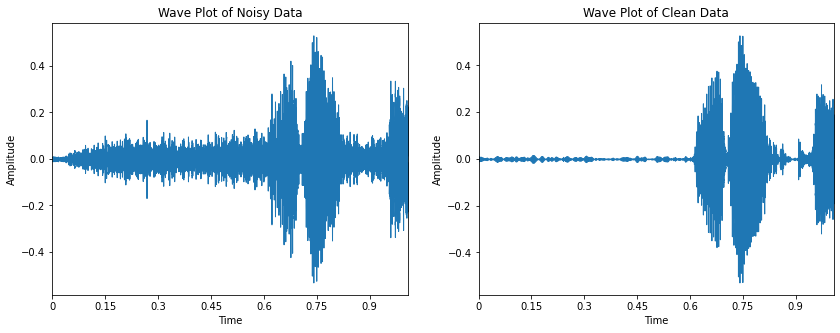

In [68]:
plt.subplots(figsize=(14, 5))

plt.subplot(1, 2, 1)
lbdp.waveplot(noisy, sr=sr)
plt.ylabel("Amplitude")
plt.title("Wave Plot of Noisy Data")

plt.subplot(1, 2, 2)
lbdp.waveplot(clean, sr=sr)
plt.ylabel("Amplitude")
plt.title("Wave Plot of Clean Data")

In [69]:
ipd.Audio(NoisySpeechTrain_path[150])

In [70]:
ipd.Audio(CleanSpeechTrain_path[30])

In [76]:
## Function to get time sries data from audio files
def get_time_series_data(files, length, isClean):
  timeSeries = np.empty((0, length), float)
  for file in files:
      x ,_ = lb.load(file, sr)
      x = lb.util.fix_length(x, 2*length)
      x = x.reshape((2, length))
      # x = x.reshape((1, x.shape[0]))
      if(isClean):
          for i in range(5):
              timeSeries = np.append(timeSeries, x, axis = 0)
      else:
          timeSeries = np.append(timeSeries, x, axis = 0)
      
  return timeSeries

In [77]:
## Storing {Noisy/Clean}speech{Train/Test}_Time Series

NSTrain_TS = get_time_series_data(NoisySpeechTrain_path, length,False)
NSTest_TS = get_time_series_data(NoisySpeechTest_path, length,False)

CSTrain_TS = get_time_series_data(CleanSpeechTrain_path, length,True)
CSTest_TS = get_time_series_data(CleanSpeechTest_path, length,True)

In [78]:
np.save(f'{baseDir}timeSeries/noisy_train.npy', NSTrain_TS)
np.save(f'{baseDir}timeSeries/clean_train.npy', CSTrain_TS)

np.save(f'{baseDir}timeSeries/noisy_test.npy', NSTest_TS)
np.save(f'{baseDir}timeSeries/clean_test.npy', CSTest_TS)

In [83]:
NSTrain_TS = np.load(f'{baseDir}timeSeries/noisy_train.npy')
NSTest_TS = np.load(f'{baseDir}timeSeries/noisy_test.npy')

CSTrain_TS = np.load(f'{baseDir}timeSeries/clean_train.npy')
CSTest_TS = np.load(f'{baseDir}timeSeries/clean_test.npy')

In [84]:
NSTrain_TS.shape

(620, 8064)

Text(0.5, 1.0, 'Wave Plot of Clean Data')

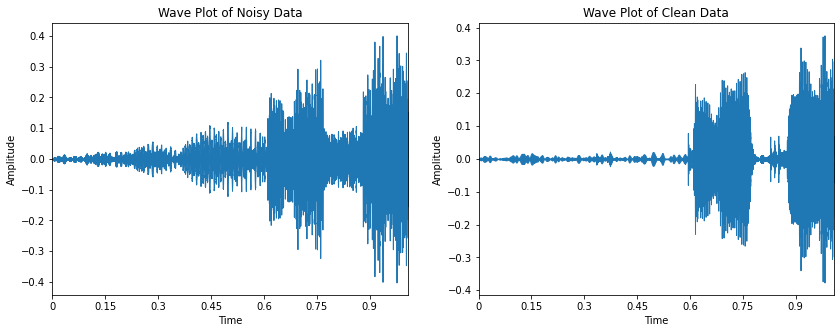

In [85]:
plt.subplots(figsize=(14, 5))

plt.subplot(1, 2, 1)
lbdp.waveplot(NSTrain_TS[0], sr=sr)
plt.ylabel("Amplitude")
plt.title("Wave Plot of Noisy Data")

plt.subplot(1, 2, 2)
lbdp.waveplot(CSTrain_TS[0], sr=sr)
plt.ylabel("Amplitude")
plt.title("Wave Plot of Clean Data")

# Calculating log-spectrograms

In [87]:
## function to get log spectrograms of noisy signals
def get_log_spectograms(signals, hopLength, frameSize, dim_square_spec):

  ## log_mag_spectograms = []
  ## log_phase_spectograms = []

  m_mag_db = np.zeros((len(signals), dim_square_spec, dim_square_spec))
  m_phase = np.zeros((len(signals), dim_square_spec, dim_square_spec), dtype=complex)
  i = 0

  for signal in signals:

    ## stft = lb.stft(signal, n_fft=frameSize, hop_length=hopLength)  ##  Calculating short time fourier transform 
    stftaudio = lb.stft(signal, n_fft=frameSize, hop_length=hopLength)
    stftaudio_magnitude, stftaudio_phase =  lb.magphase(stftaudio)
    stftaudio_magnitude_db = lb.amplitude_to_db(stftaudio_magnitude, ref=np.max)
    ##spectogram = np.abs(stft)                                       ## Converting complex values to real by taking magnitude
    ##log_spectogram = lb.amplitude_to_db(spectogram)                 ## Converting Intensity to decibels
    ##print(stftaudio_magnitude_db.shape)
    m_mag_db[i, :, :] = stftaudio_magnitude_db
    m_phase[i, :, :] = stftaudio_phase
    i = i+1

    ## log_mag_spectograms.append(stftaudio_magnitude_db)
    ## log_phase_spectograms.append(stftaudio_phase)

  return m_mag_db, m_phase


In [88]:
hop_length = 63    ## try to Tweak this
fram_size = 255     ## try to Tweak this

In [89]:
dim_square_spec = int(fram_size / 2) + 1
logSpectogram, magSpectrogram = get_log_spectograms([noisy, clean], hop_length, fram_size, dim_square_spec)

In [90]:
logSpectogram[0].shape

(128, 128)

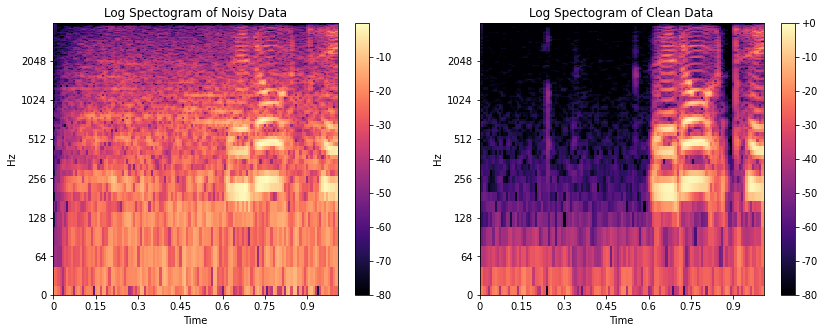

In [99]:
plt.subplots(figsize=(14, 5))

plt.subplot(1, 2, 1)
lb.display.specshow(logSpectogram[0], sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title("Log Spectogram of Noisy Data")
plt.colorbar(format="%+2.f")

plt.subplot(1, 2, 2)
lb.display.specshow(logSpectogram[1], sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title("Log Spectogram of Clean Data")
plt.colorbar(format="%+2.f")

In [92]:
x_train_mag, x_train_phase = get_log_spectograms(NSTrain_TS, hop_length, fram_size, dim_square_spec)
y_train_mag, y_train_phase = get_log_spectograms(CSTrain_TS, hop_length, fram_size, dim_square_spec)

x_test_mag, x_test_phase = get_log_spectograms(NSTest_TS, hop_length, fram_size, dim_square_spec)
y_test_mag, y_test_phase = get_log_spectograms(CSTest_TS, hop_length, fram_size, dim_square_spec)

In [93]:
## Saving log spectrograms as numpy data

np.save(f'{baseDir}Magnitude_Spectrograms/noisy_train_mag.npy', x_train_mag)
np.save(f'{baseDir}Magnitude_Spectrograms/clean_train_mag.npy', y_train_mag)

np.save(f'{baseDir}Magnitude_Spectrograms/noisy_test_mag.npy', x_test_mag)
np.save(f'{baseDir}Magnitude_Spectrograms/clean_test_mag.npy', y_test_mag)

np.save(f'{baseDir}Phase_Spectrograms/noisy_train_phase.npy', x_train_phase)
np.save(f'{baseDir}Phase_Spectrograms/clean_train_phase.npy', y_train_phase)

np.save(f'{baseDir}Phase_Spectrograms/noisy_test_phase.npy', x_test_phase)
np.save(f'{baseDir}Phase_Spectrograms/clean_test_phase.npy', y_test_phase)

In [94]:
##Loading log spectrograms stored as numpy data

x_train_mag = np.load(f'{baseDir}Magnitude_Spectrograms/noisy_train_mag.npy')
y_train_mag = np.load(f'{baseDir}Magnitude_Spectrograms/clean_train_mag.npy')

x_test_mag = np.load(f'{baseDir}Magnitude_Spectrograms/noisy_test_mag.npy')
y_test_mag = np.load(f'{baseDir}Magnitude_Spectrograms/clean_test_mag.npy')


x_train_phase = np.load(f'{baseDir}Phase_Spectrograms/noisy_train_phase.npy')
y_train_phase = np.load(f'{baseDir}Phase_Spectrograms/clean_train_phase.npy')

x_test_phase = np.load(f'{baseDir}Phase_Spectrograms/noisy_test_phase.npy')
y_test_phase = np.load(f'{baseDir}Phase_Spectrograms/clean_test_phase.npy')

In [95]:
print(x_train_mag.shape," ",x_train_phase.shape)

(620, 128, 128)   (620, 128, 128)


In [96]:
x_train = x_train_mag
y_train = x_train-y_train_mag

x_test = x_test_mag
y_test = x_test-y_test_mag

# Normalising log-spectrograms

In [100]:
def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec

def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 )/82
    return matrix_spec

def inv_scaled_in(matrix_spec):
    "inverse global scaling apply to noisy voices spectrograms"
    matrix_spec = matrix_spec * 50 - 46
    return matrix_spec

def inv_scaled_ou(matrix_spec):
    "inverse global scaling apply to noise models spectrograms"
    matrix_spec = matrix_spec * 82 + 6
    return matrix_spec

In [101]:
x_train = scaled_in(x_train)
y_train = scaled_ou(y_train)

x_test = scaled_in(x_test)
y_test = scaled_ou(y_test)

# Building CNN-Autoencoder model

In [10]:
def unet(pretrained_weights = None,input_size = (128,128,1)):
    #size filter input
    size_filter_in = 16
    #normal initialization of weights
    kernel_init = 'he_normal'
    #To apply leaky relu after the conv layer 
    activation_layer = None
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.7)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)
    up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)
    up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mae'])

    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [ ]:
generator_nn=unet()

#Save best models to disk during training
checkpoint = ModelCheckpoint(baseDir+'/model_best.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

generator_nn.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_144 (Conv2D)            (None, 128, 128, 16  160         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_138 (LeakyReLU)    (None, 128, 128, 16  0           ['conv2d_144[0][0]']             
                                )                                                           

In [102]:
## Reshaping vectors for input to CNN model (adding the channel dimension)

x_train_reshaped = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
y_train_reshaped = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1)

x_test_reshaped = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test_reshaped = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)

In [ ]:
#Training
epochs = 10
batch_size = 10
history = generator_nn.fit(x_train_reshaped, y_train_reshaped, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[checkpoint], verbose=1, validation_data=(x_test_reshaped, y_test_reshaped))

Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 0.0158 - mae: 0.1316
Epoch 00001: val_loss improved from inf to 0.00902, saving model to /content/drive/MyDrive/MS-SNSD Dataset/model_best.h5
62/62 [==============================] - 118s 2s/step - loss: 0.0158 - mae: 0.1316 - val_loss: 0.0090 - val_mae: 0.1036
Epoch 2/10
62/62 [==============================] - ETA: 0s - loss: 0.0113 - mae: 0.1188
Epoch 00002: val_loss improved from 0.00902 to 0.00900, saving model to /content/drive/MyDrive/MS-SNSD Dataset/model_best.h5
62/62 [==============================] - 133s 2s/step - loss: 0.0113 - mae: 0.1188 - val_loss: 0.0090 - val_mae: 0.1077
Epoch 3/10
62/62 [==============================] - ETA: 0s - loss: 0.0109 - mae: 0.1160
Epoch 00003: val_loss improved from 0.00900 to 0.00879, saving model to /content/drive/MyDrive/MS-SNSD Dataset/model_best.h5
62/62 [==============================] - 114s 2s/step - loss: 0.0109 - mae: 0.1160 - val_loss: 0.0088 - val_mae: 0.1034
Ep

In [103]:
## If we want to load pretrained model
generator_nn=unet(pretrained_weights = baseDir+'model_best.h5')

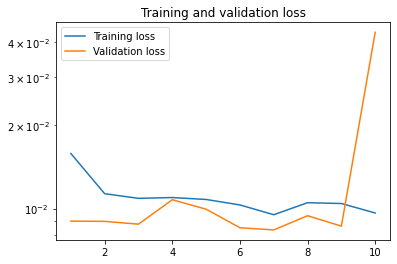

In [ ]:
#Plot training and validation loss (log scale)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.yscale('log')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Prediction

In [190]:
signal_noisy ,_ = lb.load(baseDir+'test_noisy_2.wav', sr)
signal_noisy = lb.util.fix_length(signal_noisy, 8*length)
signal_noisy = signal_noisy.reshape((8, length))

signal_clean ,_ = lb.load(baseDir+'test_clean.wav', sr)
signal_clean = lb.util.fix_length(signal_clean, 8*length)
signal_clean = signal_clean.reshape((8, length))

In [191]:
noisy_test_mag, noisy_test_phase = get_log_spectograms(signal_noisy, hop_length, fram_size, dim_square_spec)
clean_test_mag, clean_test_phase = get_log_spectograms(signal_clean, hop_length, fram_size, dim_square_spec)

In [192]:
norm_noisy_test_mag = scaled_in(noisy_test_mag)
norm_clean_test_mag = scaled_ou(clean_test_mag)

In [193]:
norm_noisy_test_mag_reshaped = norm_noisy_test_mag.reshape(norm_noisy_test_mag.shape[0], norm_noisy_test_mag.shape[1], norm_noisy_test_mag.shape[2], 1)

In [194]:
prediction = generator_nn.predict(norm_noisy_test_mag_reshaped)
inv_sca_X_pred = inv_scaled_ou(prediction)

In [195]:
inv_sca_X_pred.shape

(8, 128, 128, 1)

In [196]:
# Remove noise model from noisy speech
X_denoise = noisy_test_mag - inv_sca_X_pred[:,:,:,0]

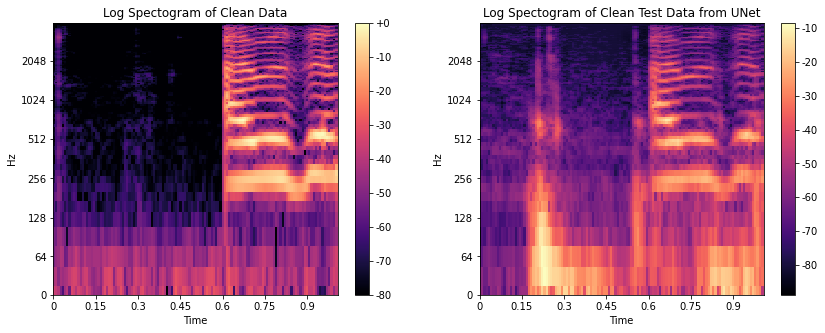

In [197]:
plt.subplots(figsize=(14, 5))

plt.subplot(1, 2, 1)
lb.display.specshow(clean_test_mag[0], sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title("Log Spectogram of Clean Data")
plt.colorbar(format="%+2.f")

plt.subplot(1, 2, 2)
lb.display.specshow(X_denoise[0], sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title("Log Spectogram of Clean Test Data from UNet")
plt.colorbar(format="%+2.f")

# Converting Log-spectrograms back to Audio

In [198]:
def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):
    """This functions reverts a spectrogram to an audio"""

    stftaudio_magnitude_rev = lb.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # taking magnitude and phase of audio
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = lb.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct

def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :
    """This functions reverts the matrix spectrograms to numpy audio"""

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

In [199]:
## rec_audio = reconstruct_audio(X_denoise, y_test_phase[0], hop_length, 8064)
rec_audio = matrix_spectrogram_to_numpy_audio(X_denoise, clean_test_phase, 8064, hop_length)

In [200]:
nb_samples = rec_audio.shape[0]

In [201]:
denoise_long = rec_audio.reshape(1, nb_samples * 8064)*10

In [202]:
sf.write(baseDir + 'output.wav', denoise_long[0, :], 8000)

In [203]:
ipd.Audio(baseDir+'test_noisy_2.wav')

In [204]:
ipd.Audio(baseDir+'output.wav')

# Refernces

Sound Of AI channel on youtube : https://www.youtube.com/c/ValerioVelardoTheSoundofAI


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
